In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
Hr_data=pd.read_csv('/content/HR_capstone_dataset.csv')

#Planing and Analyzing Pace workflow Phases
##Exploratory Data Analysis





In [3]:
Hr_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [4]:
Hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
Hr_data.rename(columns={'last_evaluation':'evaluation_score','number_project':'project_count','average_montly_hours':'monthly_hours','time_spend_company':'tenure','left':'attrition','promotion_last_5years':'promotion_5yr','salary':'salary_level','Department':'department'},inplace=True)

In [6]:
Hr_data.describe(include='all')

,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,Work_accident,attrition,promotion_5yr,department,salary_level
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


In [7]:
Hr_data.shape

(14999, 10)

In [8]:
print('missing values in each column:')
print(Hr_data.isna().sum())

missing values in each column:
satisfaction_level    0
evaluation_score      0
project_count         0
monthly_hours         0
tenure                0
Work_accident         0
attrition             0
promotion_5yr         0
department            0
salary_level          0
dtype: int64


In [9]:
Hr_data.duplicated().sum()

3008

20% of the dataset is duplicated

In [10]:
Hr_data.drop_duplicates(keep='first',inplace=True)

###Cheking Outliers

In [11]:
for column in Hr_data.columns[:-5]:
    q1, q3 = np.percentile(Hr_data[column],[25, 75])
    iqr = q3 - q1
    outlier_threshold = Hr_data[column].median() + 1.5 * iqr
    outliers = Hr_data[Hr_data[column] >= outlier_threshold].shape[0]
    print(f'{column} has {outliers} outliers')

satisfaction_level has 0 outliers
evaluation_score has 0 outliers
project_count has 145 outliers
monthly_hours has 0 outliers
tenure has 1886 outliers


<Axes: ylabel='tenure'>

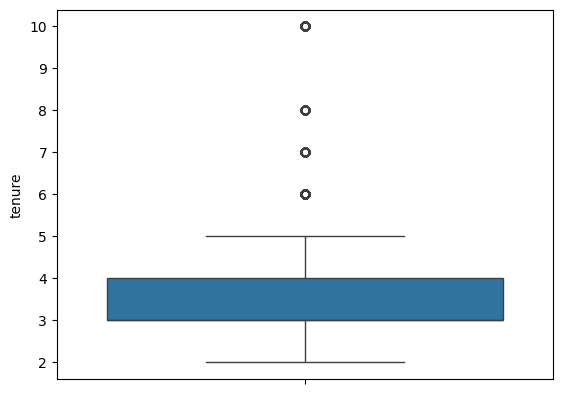

In [12]:
sns.boxplot(Hr_data['tenure'])

the obvious outliers are exist in upper limit of tenure column

***Handling Outliers of Tenure column***

In [13]:
q1, q3 = np.percentile(Hr_data['tenure'],[25,75])
iqr = q3 - q1
upper_bound=q3+1.5*iqr
lower_bound=q1-1.5*iqr

mask = (Hr_data['tenure']>upper_bound)
Hr_data[mask]


,satisfaction_level,evaluation_score,project_count,monthly_hours,tenure,Work_accident,attrition,promotion_5yr,department,salary_level
1,0.80,0.86,5,262,6,0,1,0,sales,medium
17,0.78,0.99,4,255,6,0,1,0,sales,low
34,0.84,0.87,4,246,6,0,1,0,hr,low
47,0.57,0.70,3,273,6,0,1,0,support,low
67,0.90,0.98,4,264,6,0,1,0,product_mng,medium
...,...,...,...,...,...,...,...,...,...,...
11994,0.22,0.94,3,193,10,0,0,1,management,high
11995,0.90,0.55,3,259,10,1,0,1,management,high
11996,0.74,0.95,5,266,10,0,0,1,management,high
11997,0.85,0.54,3,185,10,0,0,1,management,high


This analysis reveals that we have 824 obvious outlier in the data and they are all exist above the upper limit

<Axes: ylabel='project_count'>

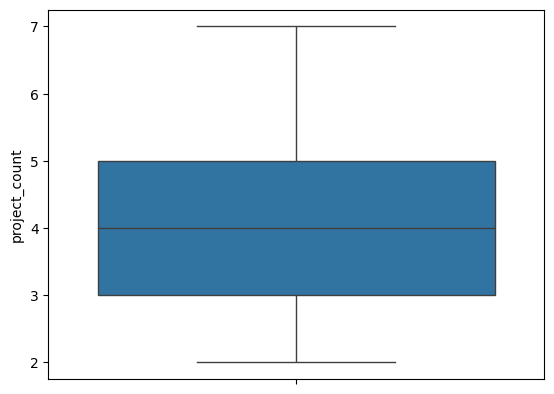

In [14]:

sns.boxplot(y=Hr_data['project_count'])

***Project count Column has no obvious ouliers to handle***

In [15]:
Hr_data['last_promotion_5yr']=Hr_data['promotion_5yr'].replace({1:'Yes',0:'No'})
Hr_data['Attrition']=Hr_data['attrition'].replace({1:'Left',0:'Stayed'})
Hr_data.groupby(['salary_level','last_promotion_5yr','attrition']).agg({'last_promotion_5yr':'count','monthly_hours':'mean','project_count':'mean','tenure':'mean','satisfaction_level':'mean','evaluation_score':'mean','tenure':'mean'})

last_promotion_5yr  monthly_hours  \
salary_level last_promotion_5yr attrition                                      
high         No                 0                         898     200.190423   
                                1                          48     202.979167   
             Yes                0                          44     194.386364   
low          No                 0                        4533     198.746746   
                                1                        1169     207.450813   
             Yes                0                          33     187.969697   
                                1                           5     177.800000   
medium       No                 0                        4374     198.866941   
                                1                         766     209.881201   
             Yes                0                         118     204.550847   
                                1                           3     180.000000   

                                           project_count    tenure  \
salary_level last_promotion_5yr attrition                            
high         No                 0               3.795100  3.402004   
                                1               3.750000  3.812500   
             Yes                0               3.772727  5.022727   
low          No                 0               3.787337  3.171630   
                                1               3.867408  3.881095   
             Yes                0               3.545455  3.787879   
                                1               3.200000  3.200000   
medium       No                 0               3.782579  3.295610   
                                1               3.925587  3.891645   
             Yes                0               3.932203  3.618644   
                                1               2.666667  3.666667   

                                           satisfaction_level  \
salary_level last_promotion_5yr attrition                       
high         No                 0                    0.653686   
                                1                    0.437500   
             Yes                0                    0.656818   
low          No                 0                    0.669404   
                                1                    0.440616   
             Yes                0                    0.676667   
                                1                    0.444000   
medium       No                 0                    0.667803   
                                1                    0.439373   
             Yes                0                    0.678220   
                                1                    0.573333   

                                           evaluation_score  
salary_level last_promotion_5yr attrition                    
high         No                 0                  0.709633  
                                1                  0.682708  
             Yes                0                  0.676136  
low          No                 0                  0.717730  
                                1                  0.722258  
             Yes                0                  0.717273  
                                1                  0.560000  
medium       No                 0                  0.714963  
                                1                  0.724634  
             Yes                0                  0.722712  
                                1                  0.703333

people with High salary 5.43% of these people left the company and they are 6% of high paid people that not promoted,and people with medium salary 15% of these people left the company and they are 15.23% of  medium paid people that not promoted and 2% of them promoted , while the people with low salary 20% of these people left the company and they are 20.42% of low paid people that not promoted and 15% promoted

In [16]:
Hr_data['total_monthly_hours']=Hr_data['monthly_hours'] * Hr_data['tenure']
Hr_data['efficiency_ratio'] = Hr_data['project_count'] / Hr_data['total_monthly_hours']
Hr_data['Work_Accident']=Hr_data['Work_accident'].replace({1:'Yes',0:'No'})

Text(0.5, 1.0, ' department count')

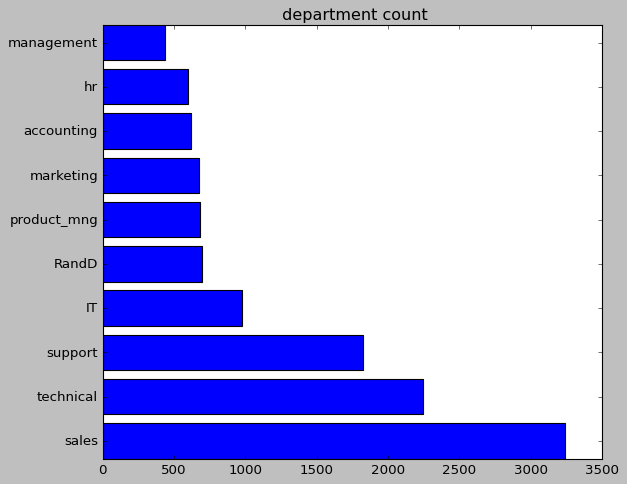

In [17]:
plt.style.use('classic')
plt.barh(Hr_data['department'].value_counts().index,Hr_data['department'].value_counts().values)
plt.tight_layout()
plt.title(' department count')

In [18]:
#study the correlation of the outcome variable which is attrition
print(Hr_data.corr()['attrition'].sort_values(ascending=False))

attrition              1.000000
total_monthly_hours    0.218584
tenure                 0.173295
monthly_hours          0.070409
project_count          0.030928
evaluation_score       0.013520
promotion_5yr         -0.044657
Work_accident         -0.125436
efficiency_ratio      -0.257653
satisfaction_level    -0.350558
Name: attrition, dtype: float64


<ipython-input-18-9ec6a287312e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(Hr_data.corr()['attrition'].sort_values(ascending=False))


'Satisfaction_level' (-0.400) has the strongest negative correlation with 'attrition'. This suggests that as the satisfaction level of employees decreases, the likelihood of attrition increases. A lower satisfaction level is often considered a significant factor in employee turnover.

'Tenure' (0.325) and 'total_monthly_hours' (0.312) still show strong positive correlations with 'attrition', indicating that longer tenures and higher total monthly hours are associated with a higher likelihood of attrition.

'Monthly_hours' (0.056), 'project_count' (0.021), and 'evaluation_score' (-0.013) have relatively weak correlations with 'attrition'. These variables may have some influence on attrition, but the relationships are not very strong.

'Promotion_5yr' (-0.038), 'Work_accident' (-0.124), and 'efficiency_ratio' (-0.289) exhibit moderate negative correlations with 'attrition'. This suggests that employees who have had promotions in the last 5 years, have experienced work accidents, or have lower efficiency ratios are more likely to stay with the company.

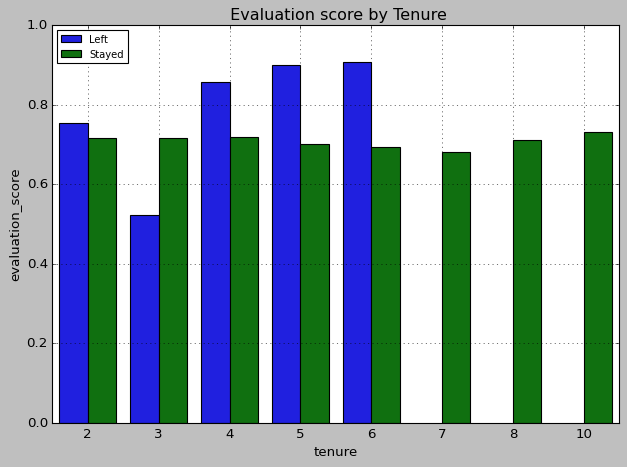

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, x='tenure', y='evaluation_score',hue='Attrition',errorbar=None)
plt.legend(loc='upper left',prop={'size': 9})
plt.grid(True)
plt.title(' Evaluation score by Tenure')
plt.tight_layout()



the visualization generally reveals that employees who have been with a company for a longer tenure may have higher proficiency compared to those with shorter tenures. This is because longer-tenured employees often accumulate more experience, skills, and knowledge over time, which can contribute to their proficiency in their roles. However, it's important to note that tenure alone is not the sole determinant of proficiency or employee retention. Various other factors, such as job satisfaction, work-life balance, growth opportunities, compensation, and organizational culture, also influence employee outcomes.

**Overall Trend:** Employees who stayed with the company consistently have higher evaluation scores across all tenure categories compared to those who left.

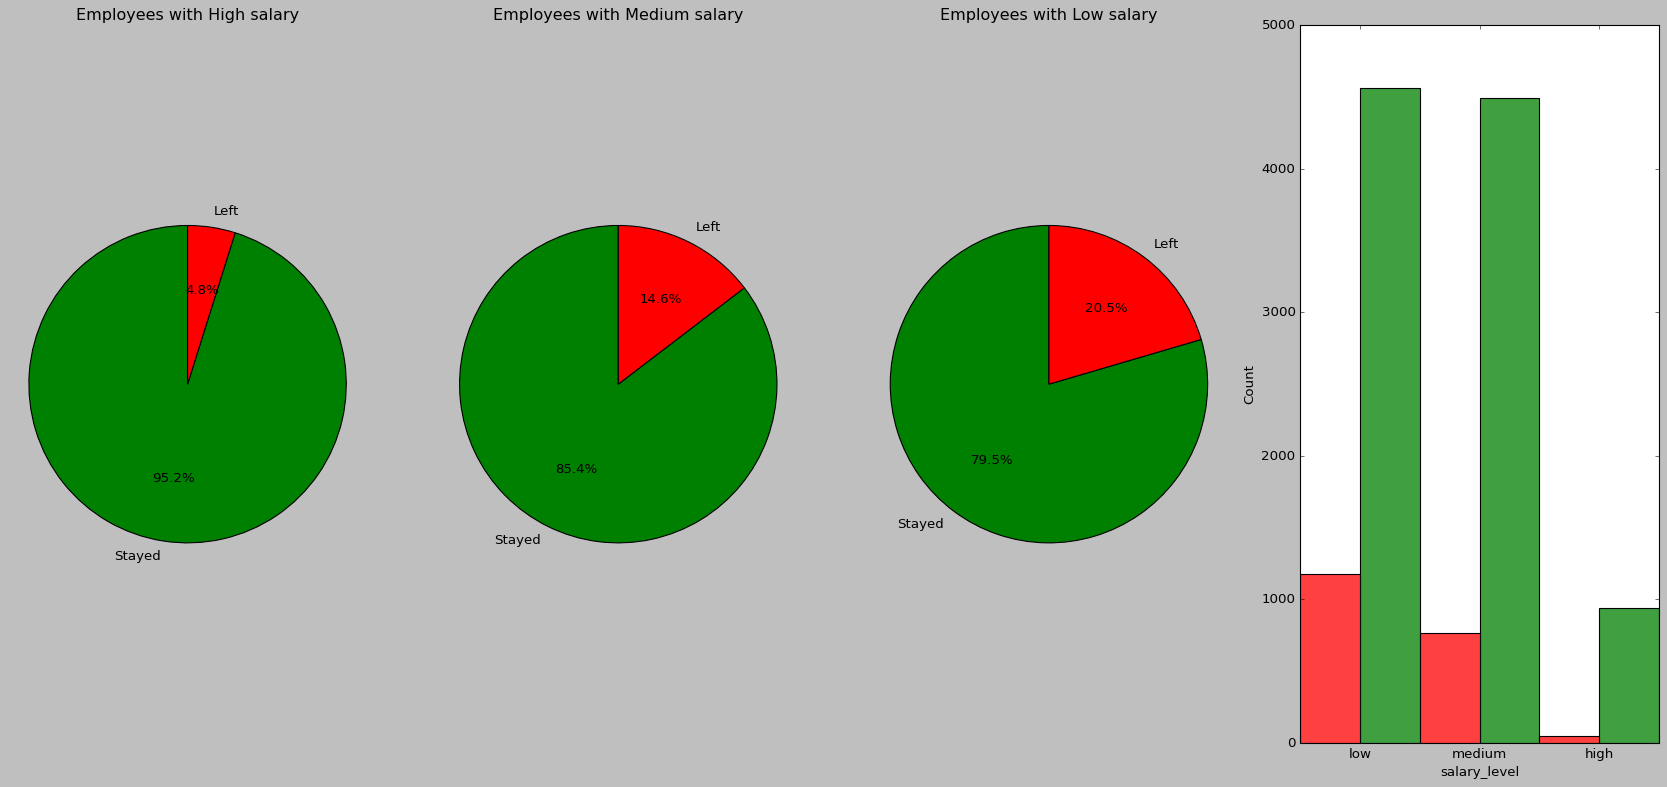

In [20]:
grp=Hr_data[['Attrition','salary_level']].groupby(['salary_level'])
import matplotlib.pyplot as plt

# Data
high = grp.get_group('high').value_counts()
med = grp.get_group('medium').value_counts()
low = grp.get_group('low').value_counts()

# Create a figure with three subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(21, 10))

# Pie chart for 'high' group
axes[0].pie(high, labels=['Stayed','Left'], autopct='%1.1f%%',colors=['g','r'],wedgeprops={"edgecolor":"k","linewidth":1}, startangle=90)
axes[0].set_title('Employees with High salary')
axes[0].axis('equal')

# Pie chart for 'medium' group
axes[1].pie(med, labels=['Stayed','Left'], autopct='%1.1f%%',colors=['g','r'],wedgeprops={"edgecolor":"k","linewidth":1}, startangle=90)
axes[1].set_title('Employees with Medium salary')
axes[1].axis('equal')

# Pie chart for 'low' group
axes[2].pie(low, labels=['Stayed','Left'], autopct='%1.1f%%',colors=['g','r'],wedgeprops={"edgecolor":"k","linewidth":1}, startangle=90)
axes[2].set_title('Employees with Low salary')
axes[2].axis('equal')
# Adjust spacing between subplots
sns.histplot(Hr_data,x='salary_level',hue='Attrition',multiple='dodge',ax=axes[3],palette=['r','g'],legend=False)
plt.tight_layout()

# Display the plot
plt.show()


The visualization reveals a distinct pattern in the attrition rates based on employee salary levels. Specifically, 20.5% of low-paid employees, 14.5% of medium-paid employees, and only 4.8% of high-paid employees left the company.


This finding suggests a correlation between salary level and attrition, indicating that lower-paid employees are more likely to leave the company compared to their higher-paid counterparts. It implies that compensation plays a significant role in employee retention.

***Suggestions:***

To address this issue, organizations may consider reviewing their salary structures and ensuring fair and competitive compensation for all employees. By providing equitable pay and recognizing the value of employees' contributions, organizations can potentially reduce attrition rates and improve overall employee satisfaction and retention.

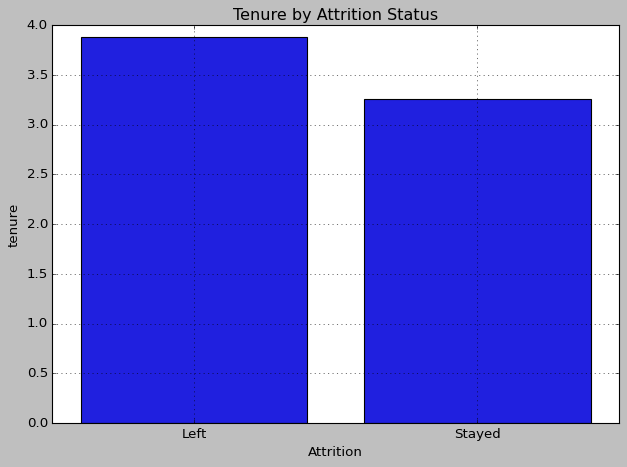

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, x='Attrition', y='tenure',errorbar=None)
plt.grid(True)
plt.title('Tenure by Attrition Status')
#plt.legend(loc='upper right',title='Last_promotion')
plt.tight_layout()

Insights:

The average tenure of employees who left the company is higher than that of those who stayed. This could imply that employees who have been with the company longer are more likely to leave, which could be indicative of issues with long-term employee satisfaction or career progression.

The company might benefit from implementing retention strategies specifically targeted at employees who have reached a certain tenure threshold, as they seem to be at a higher risk of leaving.

***Suggestions:***

To address this issue, organizations may consider implementing strategies to improve employee retention, such as providing opportunities for career development, creating a positive work culture, and conducting exit interviews to gather feedback from departing employees.

Text(0.5, 1.0, ' Variation of Satisfaction by Attrition Status')

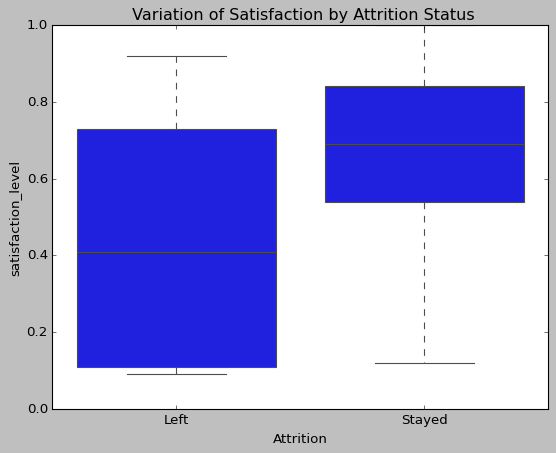

In [22]:
sns.boxplot(Hr_data,x='Attrition',y='satisfaction_level')
plt.title(' Variation of Satisfaction by Attrition Status')

**Median Satisfaction Level:** The median satisfaction level (indicated by the line within the boxes) is higher for those who have stayed compared to those who have left. This suggests that, on average, individuals who stay with the company are more satisfied than those who leave.

**Range of Satisfaction:** The range of satisfaction for those who left is broader than for those who stayed, as indicated by the height of the boxes. This implies greater variability in the satisfaction levels among those who left.

**Upper and Lower Quartiles:** The box represents the interquartile range, which shows the middle 50% of scores for each group. The box for those who stayed is tighter and positioned higher, indicating a more consistent and higher satisfaction level.

**Outliers:** The dashed lines, or "whiskers," extend to the maximum and minimum satisfaction levels within 1.5 times the interquartile range. There are no extreme values or outliers shown beyond the whiskers for either group, which suggests that satisfaction levels are fairly consistent within the range displayed.

**Satisfaction Consistency for Stayers:** The compact box for those who stayed suggests that their satisfaction levels are more clustered around a higher median, while the longer box for those who left indicates a wider spread of satisfaction levels, including both very low and moderately high values.

**Minimum Satisfaction:** The minimum satisfaction level for those who left is lower than for those who stayed, indicating that the least satisfied individuals are more likely to leave the company.

**No High Satisfaction Outliers in Leavers:** The absence of high satisfaction outliers among those who left may imply that even the more satisfied individuals among the leavers are not as satisfied as those who choose to stay.

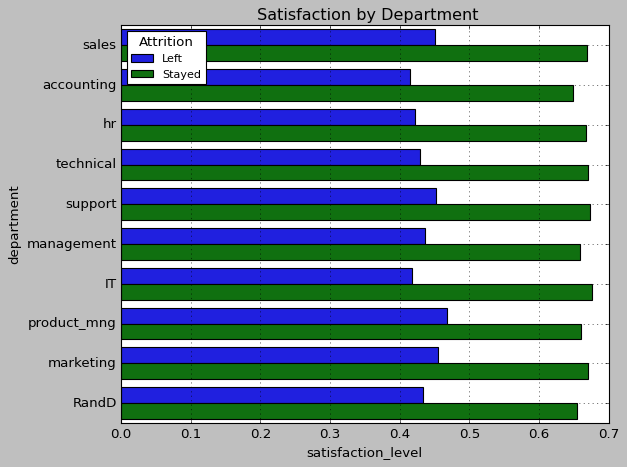

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, y='department', x='satisfaction_level',hue='Attrition',errorbar=None)
plt.grid(True)
plt.legend(loc='upper left',title='Attrition',prop={'size':10})
plt.title(' Satisfaction by Department')
plt.tight_layout()

it appears that employees who are dissatisfied or less satisfied than the others in each department are more likely to choose to leave the company. This suggests a correlation between lower satisfaction levels and employee attrition across different departments.

Text(0.5, 1.0, ' Variation of monthly hours by Attrition Status')

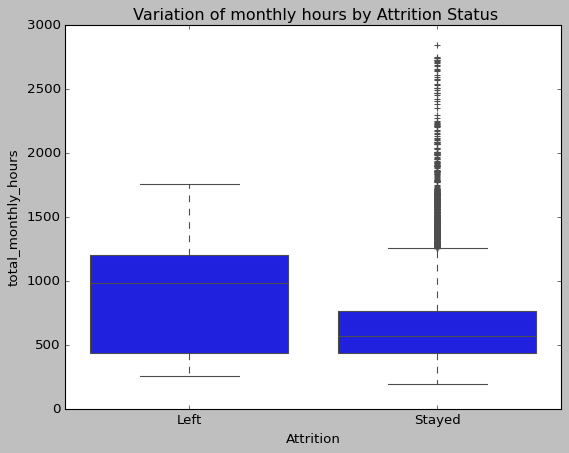

In [24]:
sns.boxplot(y=Hr_data['total_monthly_hours'],x=Hr_data['Attrition'])
plt.title(' Variation of monthly hours by Attrition Status')

The employees who left the company have great variablity while the total hours of stayed employess is skewed and have some outliers as the boxplot reveals

***Cheking Outliers in Total hours***

In [25]:
Hr_data['total_monthly_hours'].describe()

count    11991.000000
mean       681.232508
std        340.294675
min        192.000000
25%        441.000000
50%        576.000000
75%        809.000000
max       2840.000000
Name: total_monthly_hours, dtype: float64

In [26]:
q1, q3 = np.percentile(Hr_data['total_monthly_hours'],[25,75])
iqr = q3 - q1
upper_bound=q3+1.5*iqr
lower_bound=q1-1.5*iqr

mask = (Hr_data['total_monthly_hours']<=upper_bound)
Hr_data=Hr_data[mask]
Hr_data['total_monthly_hours'].describe()

count    11440.000000
mean       635.104108
std        265.424250
min        192.000000
25%        435.000000
50%        554.000000
75%        780.000000
max       1360.000000
Name: total_monthly_hours, dtype: float64

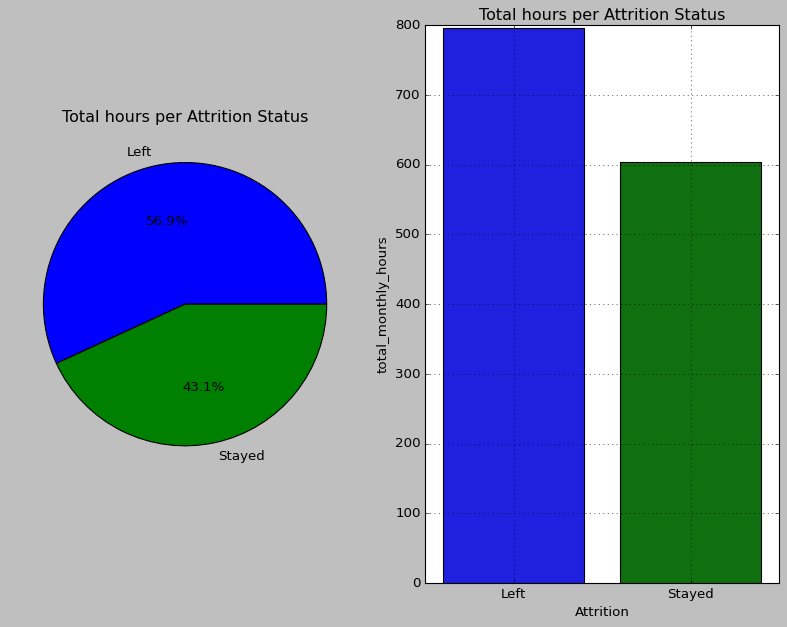

In [115]:
attrition_counts = Hr_data[['total_monthly_hours','Attrition']].groupby('Attrition').agg('mean')

# Create a pie chart
fig,axe=plt.subplots(1,2,figsize=(10, 8))
axe[0].pie(np.ravel(attrition_counts), labels=attrition_counts.index, autopct='%1.1f%%')
axe[0].set_title('Total hours per Attrition Status')

sns.barplot(Hr_data, x='Attrition', y='total_monthly_hours',hue='Attrition',axes=axe[1],errorbar=None,legend=False)
plt.grid(True)
plt.title('Total hours per Attrition Status')
plt.tight_layout()

# Display the pie chart
plt.show()

One key insight is that employees who left the company accounted for approximately 56.1% of the total hours, which corresponds to around 750 hours. This suggests that a significant portion of the overall working time was contributed by employees who are no longer with the company.

On the other hand, employees who are still in the company's service represented approximately 43.9% of the total hours, equivalent to around 590 hours. This indicates that the remaining employees, while fewer in terms of percentage and total hours, continue to contribute to the company's operations and productivity.


This insight highlights the impact of attrition on the distribution of workload and the need for effective strategies to manage employee turnover. It also emphasizes the importance of employee retention efforts.

***Suggestion:***

retaining experienced employees can contribute to maintaining productivity levels and reducing the burden on the remaining workforce.


In [28]:
print(Hr_data.corr()['satisfaction_level'].sort_values(ascending=False))

satisfaction_level     1.000000
efficiency_ratio       0.108428
evaluation_score       0.098225
Work_accident          0.043271
promotion_5yr          0.020866
monthly_hours          0.012197
project_count         -0.121788
total_monthly_hours   -0.166026
tenure                -0.196863
attrition             -0.378884
Name: satisfaction_level, dtype: float64


<ipython-input-28-ed8f2faca385>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(Hr_data.corr()['satisfaction_level'].sort_values(ascending=False))


'Efficiency_ratio' (0.112) and 'evaluation_score' (0.095) have positive correlations with 'satisfaction_level'. This suggests that higher efficiency ratios and evaluation scores are moderately associated with higher levels of satisfaction. Employees who have higher efficiency ratios and better evaluation scores tend to have higher satisfaction levels.

'Work_accident' (0.044) and 'promotion_5yr' (0.026) have weak positive correlations with 'satisfaction_level'. This implies that employees who have experienced work accidents or have received promotions in the last 5 years may have slightly higher satisfaction levels. However, the correlations are relatively weak.

'Monthly_hours' (-0.012), 'project_count' (-0.133), 'total_monthly_hours' (-0.182), and 'tenure' (-0.221) all show negative correlations with 'satisfaction_level'. This means that as monthly hours, project count, total monthly hours, and tenure increase, the satisfaction level tends to decrease. Employees who work longer hours, have higher project counts, higher total monthly hours, or longer tenure are more likely to have lower satisfaction levels.


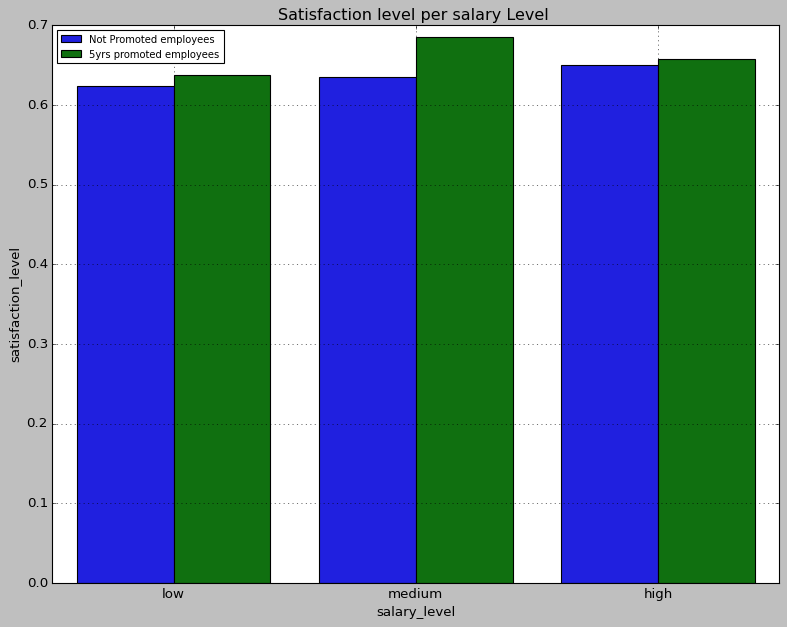

In [29]:
plt.figure(figsize=(10,8))
sns.barplot(Hr_data, x='salary_level', y='satisfaction_level',hue='last_promotion_5yr',errorbar=None)
plt.legend(loc='upper left',prop={'size': 9},labels=['Not Promoted employees','5yrs promoted employees'])
plt.grid(True)
plt.title('Satisfaction level per salary Level ')
plt.tight_layout()

There is no significant variation with satisfaction based on  salary_level groups and the last five year promotion but as the visualization reveals the promoted employees are slighlty satisfied than not promoted and as well as high paid employees are relatively satisfied than low paid people.

In [30]:
Hr_data[['Attrition','monthly_hours']].groupby('Attrition').agg(['max','min','mean'])

monthly_hours                 
                    max  min        mean
Attrition                               
Left                310  126  203.310701
Stayed              287   96  197.244817

The data suggests that employees who left the company had higher maximum monthly hours compared to those who stayed. Additionally, employees who stayed had lower minimum monthly hours. However, the mean monthly hours for both groups were relatively similar. These findings indicate that while extreme values of monthly hours may influence attrition

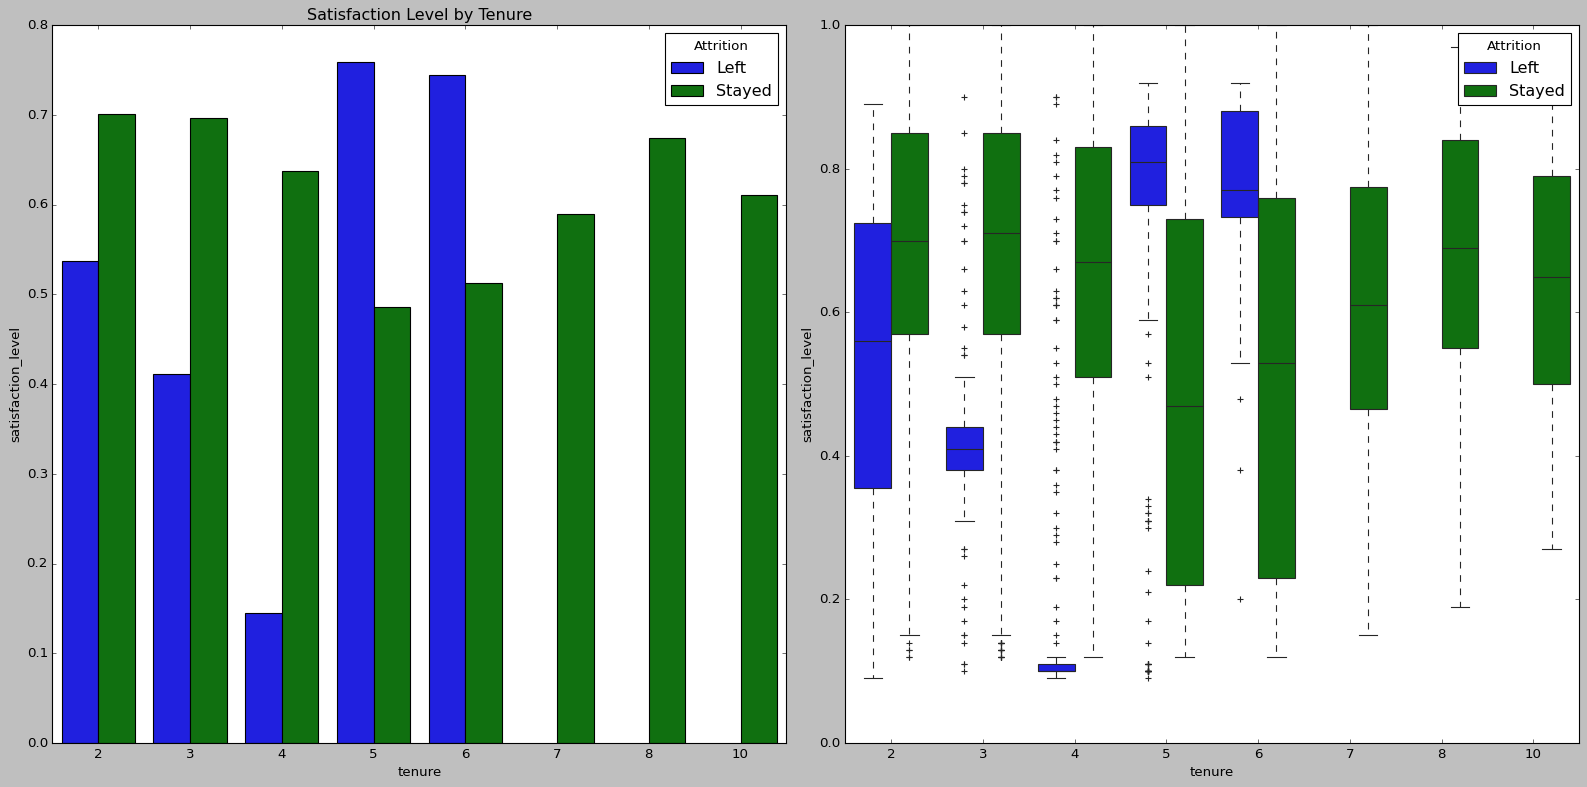

In [31]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(Hr_data, x='tenure', y='satisfaction_level',hue='Attrition',ax=ax[0],errorbar=None)
plt.legend(loc='upper right',prop={'size': 8},title='Attrition')
sns.boxplot(Hr_data,y='satisfaction_level',x='tenure',hue='Attrition',ax=ax[1])
ax[0].set_title('Satisfaction Level by Tenure')
plt.tight_layout()

The most significant difference in satisfaction levels between those who left and those who stayed appears to be at the tenure length of 5 years.
For individuals with a tenure of 2 and 3 years, and the satisfaction levels of those who stayed are significantly higher than those who left.
The satisfaction level of those who left peaks at a tenure of 4 years, though it is still lower than the satisfaction level of those who stayed.
At a tenure of 10 years,and  the satisfaction level for those who stayed is notably high compared to any other tenure length for both groups.

It could be inferred that individuals who are less satisfied are more likely to leave, particularly around the 4-5 year mark.
The higher satisfaction levels among those who have stayed could contribute to their decision to remain with the company longer.

**Long-Term Satisfaction:** The data suggests that employees with longer tenures (10 years, in this case) who stay with the company report high satisfaction levels. This implies that employees who survive the earlier, potentially more volatile periods of employment tend to find a lasting fit within the company.


**Retention Strategies:** Developing targeted retention strategies for employees at different tenure stages could be beneficial. For instance, employees with around 5 years of tenure might benefit from career development opportunities or other engagement strategies.

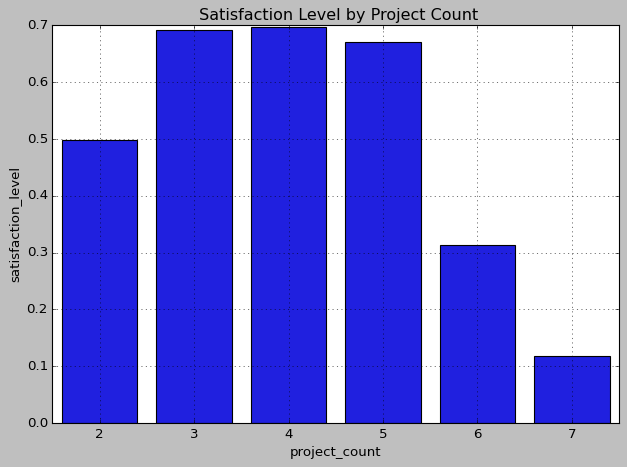

In [32]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, y='satisfaction_level', x='project_count',errorbar=None)
plt.grid(True)
plt.title(' Satisfaction Level by Project Count')
plt.tight_layout()

**Peak Satisfaction:** The highest level of satisfaction is associated with individuals who have been involved with 4 projects. This suggests that at this project count, employees are most satisfied.

**Decreasing Satisfaction with High Project Counts:** There's a noticeable decline in satisfaction levels as the project count increases beyond 4. This could indicate that overcommitment or overwork might lead to decreased satisfaction.

**Lowest Satisfaction at Extreme Project Counts:** The lowest levels of satisfaction are seen at the extremes of the project count spectrum - at 2 and 7 projects. This may imply that too few projects could be associated with under-engagement or a lack of opportunity, while too many projects could lead to burnout or stress.

**Optimal Project Engagement:** The data suggests that there is an optimal level of project engagement (around 3 to 4 projects) that correlates with higher satisfaction levels, indicating a balance between challenge and workload.

**Potential for Burnout:** The sharp decrease in satisfaction from 4 to 5 projects and then again at 7 projects could suggest that employees may experience burnout or diminishing returns in terms of satisfaction when taking on too many projects.

**Project Variety and Satisfaction:** Assuming that each project is different, this chart might also suggest that variety in work can contribute positively to satisfaction up to a point, after which it becomes overwhelming.

**Implications for Management:** Management might use this data to avoid overloading employees with projects and to find the sweet spot that maximizes satisfaction and productivity.

**Data-Driven Workload Allocation:** Organizations could leverage such insights to tailor workload allocation policies, ensuring employees are engaged but not overburdened.

**Need for Supportive Measures:** For employees handling many projects (5 or more), the company might consider implementing supportive measures to maintain or improve satisfaction levels.

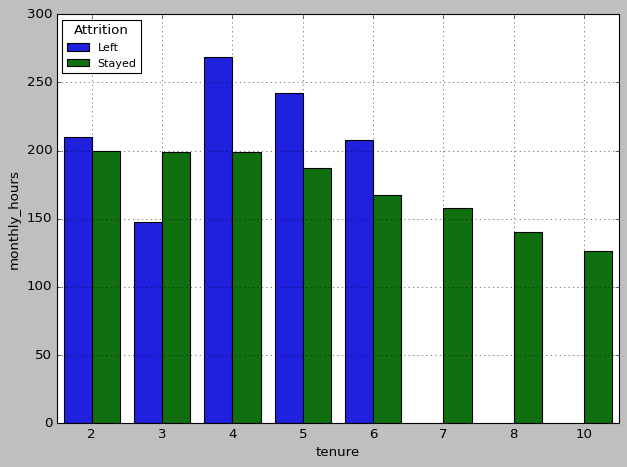

In [33]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, y='monthly_hours', x='tenure',hue='Attrition',errorbar=None)
plt.grid(True)
plt.legend(loc='upper left',title='Attrition',prop={'size':10})
plt.tight_layout()

**Peak Work Hours:** Employees with a tenure of 4 and 5 years who left the company appear to have worked the highest average monthly hours compared to other tenures. This suggests a possible correlation between higher work hours and the decision to leave the company, potentially due to burnout or work-life balance issues.

**Work Hours and Tenure:** For both employees who left and those who stayed, there is a general decrease in average monthly hours as tenure increases, especially after the 5-year mark. This could indicate that more experienced employees are either more efficient or that their workload is adjusted over time.

**Work Hours for Stayers:** The average monthly hours for employees who stayed with the company are generally lower than for those who left, across all tenure lengths. This may reflect that sustainable work hours contribute to longer tenure and better employee retention.

**Initial Tenure Period:** Employees in their initial tenure period (2-3 years) who left the company were working fewer hours than those with 4-5 years of tenure but still more than those who stayed. There might be different factors contributing to the decision to leave at this stage, possibly including career development opportunities or job satisfaction aspects other than workload.

**Long-Term Employees:** At the 10-year mark, the average monthly hours for employees who stayed drops significantly, potentially indicating a more comfortable and established work routine or a reward for long service in the form of reduced hours.

**Potential Overwork Issue:** The significant increase in average monthly hours for employees who left at the 4-5 year tenure could be an indicator of overwork leading to attrition. It suggests a critical period where workload management could be crucial in retaining staff.

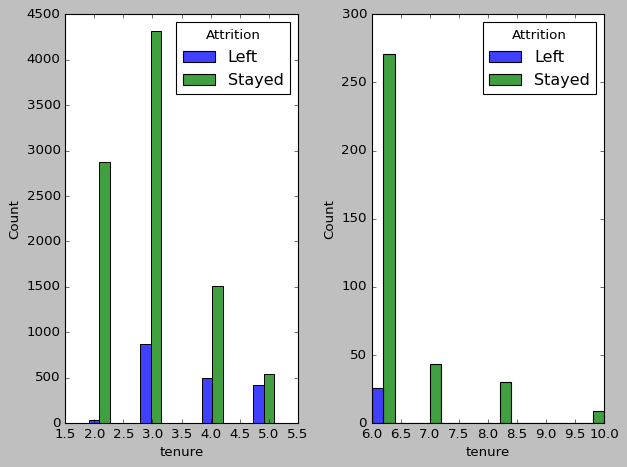

In [112]:
filt=Hr_data['tenure']>=6
long_term=Hr_data[filt]
short_term=Hr_data[~filt]
fig,ax=plt.subplots(1,2,figsize=(8,6))
sns.histplot(short_term, x='tenure',hue='Attrition',shrink=2,ax=ax[0],multiple='dodge')
sns.histplot(long_term, x='tenure',hue='Attrition',ax=ax[1],multiple='dodge')


plt.tight_layout()

The company has few employees with long tenure while has a alot of employees with short term tenure around (4,5) years , and alot of them start leaving the company when they reach their third year tenure as well as the number of stayed employees decreasing over time from fifth year tenure and onward and the number of left employees vanished in sixth year tenure ,it seems that if the employees survived the first 5-6 years that means stick to the company's service

***suggestions for employees retention***

**Third-Year Retention Plan:** Introduce a personalized review and career planning session for employees around their third year to address any concerns and plan future growth within the company.

**Post-Fifth Year Engagement:** Recognize and reward employees reaching the five-year tenure with bonuses, recognition programs, or advancement opportunities.

**Career Development:** Create clear paths for career progression and offer ongoing training and development programs to encourage employees to envision a long-term future with the company.

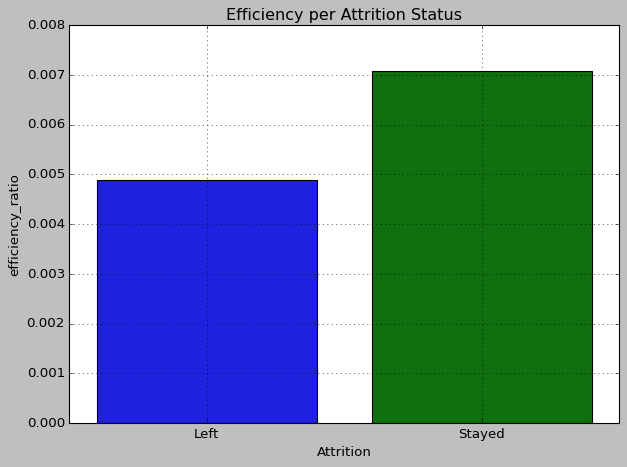

In [34]:
plt.figure(figsize=(8,6))
sns.barplot(Hr_data, x='Attrition', y='efficiency_ratio',hue='Attrition',errorbar=None,legend=False)
plt.grid(True)
plt.title('Efficiency per Attrition Status')
plt.tight_layout()

the Visuaization reveales that the Effieciency Ratio of Stayed Employees is significantely greater than the Effieciency Ratio of those who left The company because  of their  high average of monthly hours


the employees who remained with the organization were more productive and efficient in their roles compared to those who chose to leave.


---
---


##Global Insights

**The Attrition**

Employees who Left the company according to our Analysis they were influenced by these factors:dissatisfaction,mid Tenure ,High Total Monthly hours, Low efficiency ratio , Low Salary Level


*  Employees who Left the company they were mostly dissatisfied  as the Satisfaction level is the Major factor

*  Employees who left the company they were dissatisfied at the begining of their career compared to those who still in the company's service, who left became increasingly dissatisfied over time around the first (4,5)years of their tenure if they survive this critical period they will get more satisfied and they will stick to the company's service


*   Employees who left the company because of their  High Total average Monthly hours tend to decrease their efficiency ratio compared to those who still in the company's service


*  lower-paid employees are more likely to leave the company compared to their higher-paid counterparts. It implies that compensation plays a significant role in employee retention.


---


---


##Implementations and Strategies

to address the various factors leading to employee attrition, the most effective strategies would be those that directly target the primary causes of dissatisfaction and turnover.

***Enhancing Job Satisfaction through Engagement and Recognition:***
* Develop a robust recognition program that regularly acknowledges employee achievements, both big and small.

* Implement a comprehensive engagement strategy that includes regular team-building activities and opportunities for cross-departmental collaboration.

***Flexible Work Arrangements to Manage Workload:***
* Offer flexible working hours and the possibility of remote work to help employees balance their personal and professional lives.

* Introduce a system that allows employees to take time off when they've worked excessive hours to prevent burnout.

***Career Development and Growth Opportunities:***
* Establish clear career paths and professional development opportunities, including training programs and mentorship, to encourage growth within the company.

* Perform regular career check-ins and create personalized development plans.

***Performance-Based Compensation and Rewards:***
* Adjust salary structures based on market competitiveness and internal equity to ensure fair compensation.

* Implement a performance-based bonus system that rewards efficiency and contribution rather than just hours worked.

***Retention Analysis and Proactive Interventions:***
* Conduct 'stay interviews' to understand what motivates employees to remain with the company and what might cause them to leave.

* Analyze exit interview data to identify trends and areas for improvement.






#Construction Pace workflow phase
##Feature Engeneering

In [35]:
Hr_data['Attrition'].value_counts(normalize=True)*100

Stayed    83.907343
Left      16.092657
Name: Attrition, dtype: float64

It seems there is significant imbalanced classes between those who left and who stayed in the dataset

In [36]:
data_majority = Hr_data[Hr_data["Attrition"] == "Stayed"]
data_minority = Hr_data[Hr_data["Attrition"] == "Left"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["Attrition"].value_counts(normalize=True)*100

Stayed    50.0
Left      50.0
Name: Attrition, dtype: float64

In [37]:
filter=['Attrition','last_promotion_5yr','Work_Accident','tenure','monthly_hours','project_count','evaluation_score']
Selected_Data=data_upsampled.loc[:,~data_upsampled.columns.isin(filter)]

In [38]:
Transformed_data=Selected_Data.copy()
Transformed_data['salary_level']=Transformed_data['salary_level'].astype('category').cat.codes
Transformed_data=pd.get_dummies(Transformed_data,columns=['department'],drop_first=True)

In [39]:
X=Transformed_data.loc[:,~Transformed_data.columns.isin(['attrition'])]
y=Transformed_data['attrition']

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

##Build a Machine Learning Model

**GridSearchCV to find the best hyperparameter tuning for Random Forest model**

In [41]:
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

**GridSearchCV to find the best hyperparameter tuning for XGBClassifier  model**

In [42]:
xgb=XGBClassifier(random_state=0)
# Create a dictionary of hyperparameters to tune
### YOUR CODE HERE ###
param_grid = {
    'max_depth': [3, 4, 5,6,7,None],
    'learning_rate': [0.1,0.2,0.3],
    'n_estimators': [75, 100, 120],
    'min_child_weight': [1, 2, 3],
}
 #Define a dictionary of scoring metrics to capture
### YOUR CODE HERE ###
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)


In [60]:
%%time
#rf_cv.fit(X_train, y_train)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


,satisfaction_level,Work_accident,promotion_5yr,salary_level,total_monthly_hours,efficiency_ratio,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.58,0,0,1,645,0.006202,0,0,0,0,0,0,1,0,0
1,0.82,0,0,1,606,0.003300,0,0,0,0,0,0,1,0,0
2,0.45,0,0,1,579,0.008636,0,0,0,0,0,0,1,0,0
3,0.78,0,0,1,741,0.006748,0,0,0,0,0,0,1,0,0
4,0.49,0,0,1,428,0.007009,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19193,0.78,0,0,2,1280,0.003906,0,0,0,0,0,0,1,0,0
19194,0.09,0,0,0,972,0.006173,0,0,0,0,0,1,0,0,0
19195,0.11,0,0,2,1056,0.006629,0,0,0,0,0,0,0,0,1
19196,0.10,0,0,2,1220,0.005738,0,0,0,0,0,0,0,0,1


In [44]:
%%time
#grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [45]:
import pickle
path='/content/'
#with open(path+'grid_search_model.pickle','wb') as to_write:
 # pickle.dump(grid_search,to_write)

In [46]:
#with open(path+'rf_cv_model.pickle','wb') as to_write:
 # pickle.dump(rf_cv,to_write)

In [47]:

with open('/content/rf_cv_model.pickle','rb') as to_read:
    rf_cv= pickle.load(to_read)
best_params = rf_cv.best_params_
print("Best Hyperparameters of random forest model:", best_params,'Best Score of random forest ML Model',rf_cv.best_score_)

Best Hyperparameters of random forest model: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75} Best Score of random forest ML Model 0.9973896228100598


In [48]:
with open(path+'grid_search_model.pickle', 'rb') as to_read:
    grid_search= pickle.load(to_read)
best_params = grid_search.best_params_
print("Best Hyperparameters of XGboost ML Model:", best_params,'Best Score of XGboost ML Model',grid_search.best_score_)

Best Hyperparameters of XGboost ML Model: {'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 120} Best Score of XGboost ML Model 0.9914437054970205


### **Build a random forest model**
---



In [49]:
rf_model=RandomForestClassifier(n_estimators=75,min_samples_leaf=1,min_samples_split=2,max_features=4,random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf=rf_model.predict(X_test)

###**Build a boosing Machine Learning Model XGBoost Model**

In [50]:
Xgb_model=XGBClassifier(learning_rate= 0.3,max_depth= 7,min_child_weight=1,n_estimators=120,random_state=42)
Xgb_model.fit(X_train,y_train)
y_pred_Xgb=Xgb_model.predict(X_test)



---


---



#**Executing Phase of the pace workflow**



---


###**Evaluating The Random Forest model**

In [51]:
print("Accuracy of Random Forest model:", "%.3f" % metrics.accuracy_score(y_test, y_pred_rf))
print("Precision of Random Forest model:", "%.3f" % metrics.precision_score(y_test, y_pred_rf))
print("Recall of Random Forest model:", "%.3f" % metrics.recall_score(y_test, y_pred_rf))
print("F1 Score of Random Forest model:", "%.3f" % metrics.f1_score(y_test, y_pred_rf))

Accuracy of Random Forest model: 0.994
Precision of Random Forest model: 0.991
Recall of Random Forest model: 0.997
F1 Score of Random Forest model: 0.994


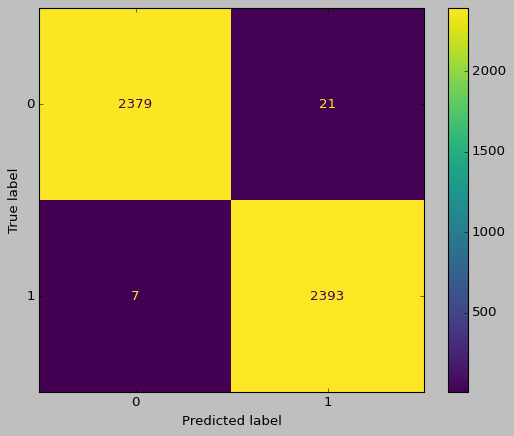

In [52]:
cm = metrics.confusion_matrix(y_test, y_pred_rf, labels =rf_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels =rf_model.classes_)
disp.plot()

###**Evaluating XGBoost Machine Learning Model**

In [53]:
print("Accuracy of Xgboost ML Model:", "%.3f" % metrics.accuracy_score(y_test, y_pred_Xgb))
print("Precision of Xgboost ML Model:", "%.3f" % metrics.precision_score(y_test, y_pred_Xgb))
print("Recall of Xgboost ML Model:", "%.3f" % metrics.recall_score(y_test, y_pred_Xgb))
print("F1 Score of Xgboost ML Model:", "%.3f" % metrics.f1_score(y_test, y_pred_Xgb))

Accuracy of Xgboost ML Model: 0.993
Precision of Xgboost ML Model: 0.990
Recall of Xgboost ML Model: 0.996
F1 Score of Xgboost ML Model: 0.993


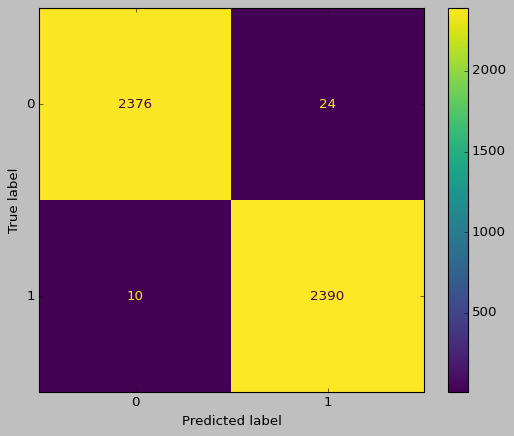

In [54]:
cm = metrics.confusion_matrix(y_test, y_pred_Xgb, labels =Xgb_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels =Xgb_model.classes_)
disp.plot()

---
##Choosing The best Model
After Testing These models based on recent Evaluations the best Evaluation  blongs to Tree_based_learning ML model working using bagging or (Bootsrap Agreggation) which is in Ensembling model or Random Forest ML Model

**Tree_based Crosstab**

In [55]:
Prediction_Tree_based=pd.DataFrame(dict(Actual=y_test,Predicted=y_pred_rf))
pd.crosstab(index=Prediction_Tree_based['Actual'],columns=Prediction_Tree_based['Predicted'])

Predicted,0,1
Actual,,
0,2379,21
1,7,2393


True Positive (TP): 99.71%

False Negative (FN): 0.29%

False Positive (FP): 0.88%

True Negative (TN): 99.12%

**Xgboost Crosstab**

In [56]:
Prediction_Xgboost=pd.DataFrame(dict(Actual=y_test,Predicted=y_pred_Xgb))
pd.crosstab(index=Prediction_Xgboost['Actual'],columns=Prediction_Xgboost['Predicted'])

Predicted,0,1
Actual,,
0,2376,24
1,10,2390



True Positive (TP): 99.58%

False Negative (FN): 0.42%

False Positive (FP): 1.00%

True Negative (TN): 99.00%



---


After Testing These models based on recent Evaluations the best Evaluation blongs to Tree_based_learning ML model  using bagging or (Bootsrap Agreggation) which is in Ensembling model or Random Forest ML Model

In [57]:
Prediction_Tree_based=Prediction_Tree_based.merge(data_upsampled["Attrition"],left_index=True,right_index=True)


In [58]:
Prediction_Tree_based

,Actual,Predicted,Attrition
14753,1,1,Left
9505,0,0,Stayed
14952,1,1,Left
4968,0,0,Stayed
12284,1,1,Left
...,...,...,...
4433,0,0,Stayed
12838,1,1,Left
7988,0,0,Stayed
12584,1,1,Left


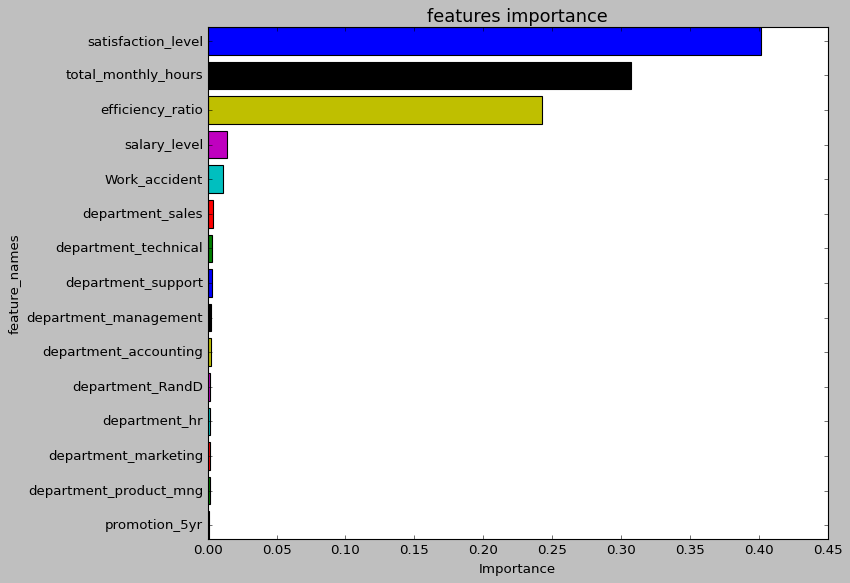

In [59]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]
# Print feature importances
plt.figure(figsize=(10,8))

for feature_name, importance in zip(sorted_feature_names, sorted_feature_importances):
    plt.barh(feature_name,importance)
    plt.title('features importance',fontsize=16)
    plt.xlabel('Importance',fontsize=12)
    plt.ylabel('feature_names',fontsize=12)

The feature importance Explains the most effictive features in our Tree_based_learning model that helped us to make this prediction model  with high accuracy of attrition ,and of course because  of  significant correlation between each important feature and our outcome variable which is Attrition column